In [24]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [25]:
# Use a random seed to have the same aleatorization every runtime.
np.random.seed(0)

In [26]:
def ACKLEY_FUNCTION(x, a=20, b=0.2, c=2*math.pi) -> float:
  '''
  Ackley function is used as the objetive function.
  '''
  # Number of dimensions.
  d = 2
  return (-a * math.exp(-b * math.sqrt(1/d * np.sum(np.square(x))))
  - math.exp(1/d * np.sum(np.cos(c * x))) + a + math.exp(1))

In [27]:
class Optimizator:
  '''
  Generic ompitimizator class that is going to be used by the 1:M and M:M optimization techniques 
  classes.
  '''
  def __init__(self, function, epochs=100) -> None:
      self.function = function
      self.epochs = epochs
      self.LOWER_BOUND = -32.768
      self.UPPER_BOUND = 32.768
      self.children = dict()
      self.best_history = []

  # Returns the evaluation value for the objetive function.
  def evaluate(self, children_to_eval) -> float:
    return self.function(children_to_eval)

  # Generates a children using a random local search for a given father.
  def mutate(self, father):
    ans = father.copy()
    ans[0] += (np.random.uniform(-2, 2) / (2 ** np.random.randint(0, 3)))
    ans[1] += (np.random.uniform(-2, 2) / (2 ** np.random.randint(0, 3)))
    return np.clip(ans, self.LOWER_BOUND, self.UPPER_BOUND)  

In [28]:
class OneFatherManyChildren(Optimizator):
  def __init__(self, function, epochs=100) -> None:
    super().__init__(function, epochs)
    self.best_history = []

  def runOptimization(self, n=10):
    # Generate a random (2,) shape numpy array as the initial father.
    self.father = np.random.uniform(self.LOWER_BOUND, self.UPPER_BOUND, size=(2,))

    for _ in range(self.epochs):
      self.children.clear()

      # Generate n children and store its evaluation results.
      for _ in range(n):
        new_children = self.mutate(self.father)
        self.children[tuple(new_children)] = self.evaluate(new_children)

      # Assign father as the best children.
      self.father = np.array(min(self.children, key=self.children.get)).copy()
      # Store best value of iteration.
      self.best_history.append(self.father.copy())

    return self.father, self.best_history

class OneFatherManyChildrenGenerational(Optimizator):
  def __init__(self, function, epochs=100) -> None:
    super().__init__(function, epochs)
    self.best_history = []

  def runOptimization(self, n=10):
    # Generate a random (2,) shape numpy array as the initial father.
    self.father = np.random.uniform(self.LOWER_BOUND, self.UPPER_BOUND, size=(2,))

    for _ in range(self.epochs):
      self.children.clear()
      
      # Generate n children and store its evaluation results.
      for _ in range(n):
        new_children = self.mutate(self.father)
        self.children[tuple(new_children)] = self.evaluate(new_children)

      # Select the best children.
      best_children = np.array(min(self.children, key=self.children.get)).copy()
      
      # Compare and check if its better than father (father = best(children + father)).
      self.father = best_children.copy() if self.evaluate(best_children) < self.evaluate(self.father) else self.father.copy()
      # Store best value of iteration.
      self.best_history.append(self.father.copy())

    return self.father, self.best_history 

class ManyFatherManyChildren(Optimizator):
  def __init__(self, function, epochs=100) -> None:
    super().__init__(function, epochs)
    self.best_history = []

  def runOptimization(self, n=5, m=10):
    # Generate a random list of (2,) shape numpy array as the initial fathers.
    self.fathers = [np.random.uniform(self.LOWER_BOUND, self.UPPER_BOUND, size=(2,)) for _ in range(n)]

    for _ in range(self.epochs):
      self.children.clear()

      # For each children that it is going to be generated mutate a random father.
      for _ in range(m):
        new_children = self.mutate(self.fathers[np.random.randint(0, n)])
        self.children[tuple(new_children)] = self.evaluate(new_children)

      # Select the best group of n children and replace fathers.
      self.fathers = np.array(list(dict(sorted(self.children.items(), key=lambda x: x[1])[:n]).keys())).copy()
      # Select the best father of the group.
      self.best_father = np.array(min(self.fathers, key=self.evaluate)).copy()
      # Store best father.
      self.best_history.append(self.best_father.copy())

    return self.best_father, self.best_history

class ManyFatherManyChildrenGenerational(Optimizator):
  def __init__(self, function, epochs=100) -> None:
    super().__init__(function, epochs)
    self.best_history = []

  def runOptimization(self, n=5, m=10):
     # Generate a random list of (2,) shape numpy array as the initial fathers.
    self.fathers = [np.random.uniform(self.LOWER_BOUND, self.UPPER_BOUND, size=(2,)) for _ in range(n)]

    for _ in range(self.epochs):
      self.children.clear()

      # For each children that it is going to be generated mutate a random father.
      for _ in range(m):
        new_children = self.mutate(self.fathers[np.random.randint(0, n)])
        self.children[tuple(new_children)] = self.evaluate(new_children)

      # Insert fathers into the group of children.
      for father in self.fathers:
        self.children[tuple(father)] = self.evaluate(father)

      # Select best n(children + father) and replace fathers list.
      self.fathers = np.array(list(dict(sorted(self.children.items(), key=lambda x: x[1])[:n]).keys())).copy()
      # Select the best father and store it into the history.
      self.best_father = np.array(min(self.fathers, key=self.evaluate)).copy()
      self.best_history.append(self.best_father.copy())

    return self.best_father, self.best_history

In [29]:
def plot_curve(evaluated, filename):
  '''
  Function to generate a plot for the best value found on each iteration.
  '''
  plt.figure(figsize=(16, 16))
  plt.title('Best children for each epoch in optimization algorithm')
  plt.xlabel('Iteration', fontsize=18)
  plt.ylabel('Value of Ackley function', fontsize=16)
  plt.plot(evaluated)
  plt.show()
  plt.savefig('./img/{}.png'.format(filename))

In [30]:
def do_plot_2d_map(coordinates, technique, filename) -> list():
  '''
  Function to generate the 2D map of the values of x (input) on each axis.
  '''
  evaluated = [ACKLEY_FUNCTION(element) for element in coordinates]
  x, y = coordinates.T
  plt.figure(figsize=(16, 16))
  plt.scatter(x, y, c=evaluated, s=1)
  plt.xlabel('X axis', fontsize=18)
  plt.ylabel('Y axis', fontsize=16)
  plt.title('Results for Ackley function using {}'.format(technique))
  plt.show()
  plt.savefig('./img/{}.png'.format(filename))
  return evaluated

In [31]:
# Optimization results for one father many children.
optimization_algorithm_ofmc = OneFatherManyChildren(ACKLEY_FUNCTION, epochs=2000)
best, coordinates = optimization_algorithm_ofmc.runOptimization()
print("Best values for x using one father many children:", best)

Best values for x using one father many children: [0.92741657 0.20460595]


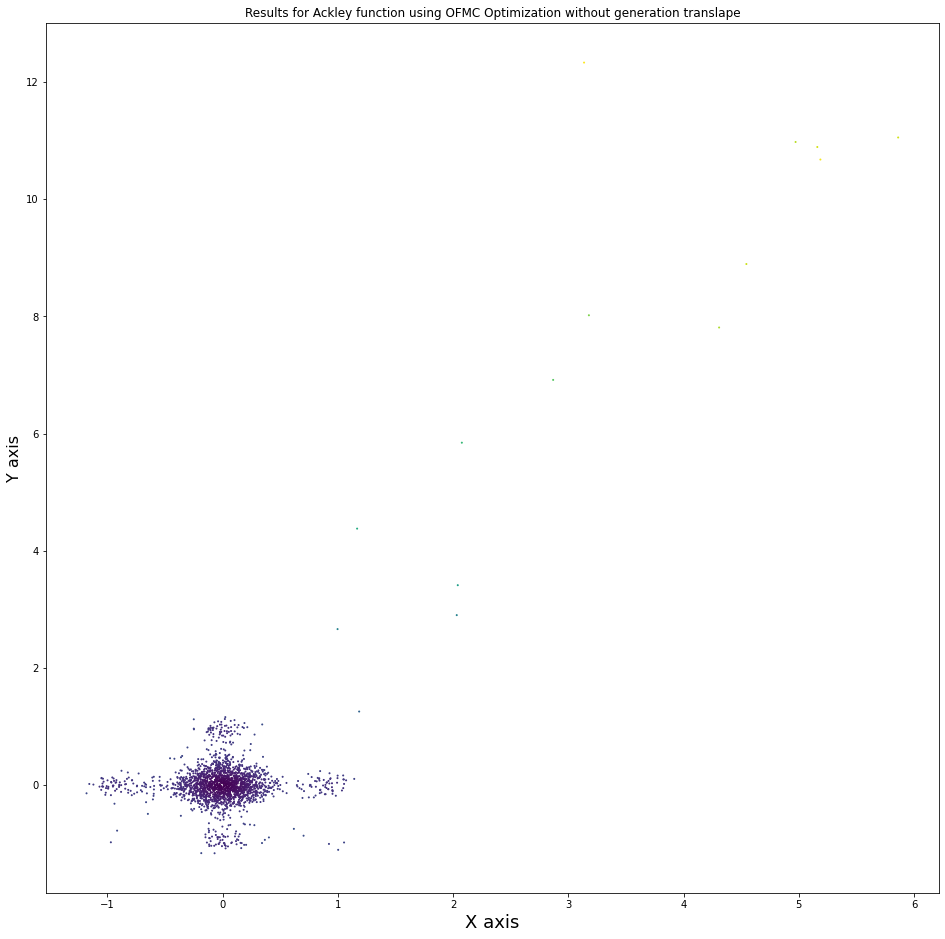

<Figure size 432x288 with 0 Axes>

In [32]:
coordinates = np.asarray(coordinates)
evaluated = do_plot_2d_map(coordinates, 'OFMC Optimization without generation translape', 'om_2d')

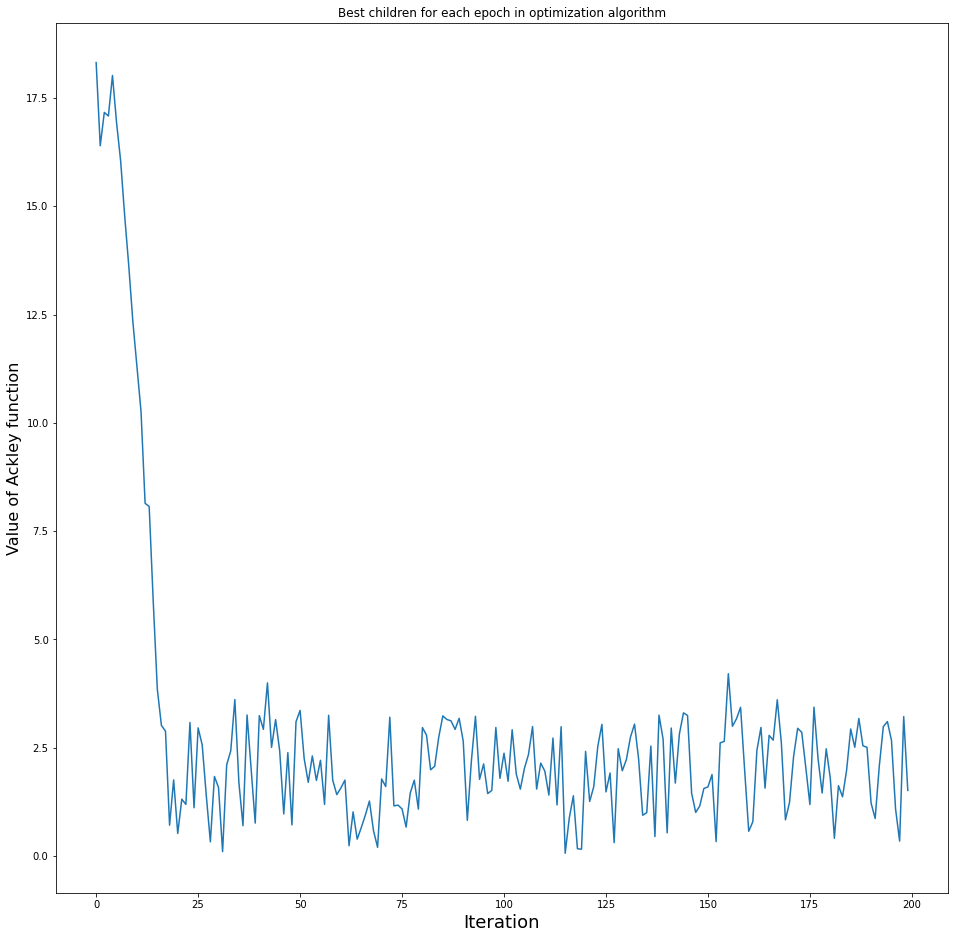

<Figure size 432x288 with 0 Axes>

In [33]:
plot_curve(evaluated[:200], 'om_curve')

In [34]:
# Optimization results for one father many children with generational transpose.
optimization_algorithm_ofmcg = OneFatherManyChildrenGenerational(ACKLEY_FUNCTION, epochs=2000)
best, coordinates = optimization_algorithm_ofmcg.runOptimization()
print("Best values for x using one father many children with generation translape:", best)

Best values for x using one father many children with generation translape: [ 0.00012727 -0.00431438]


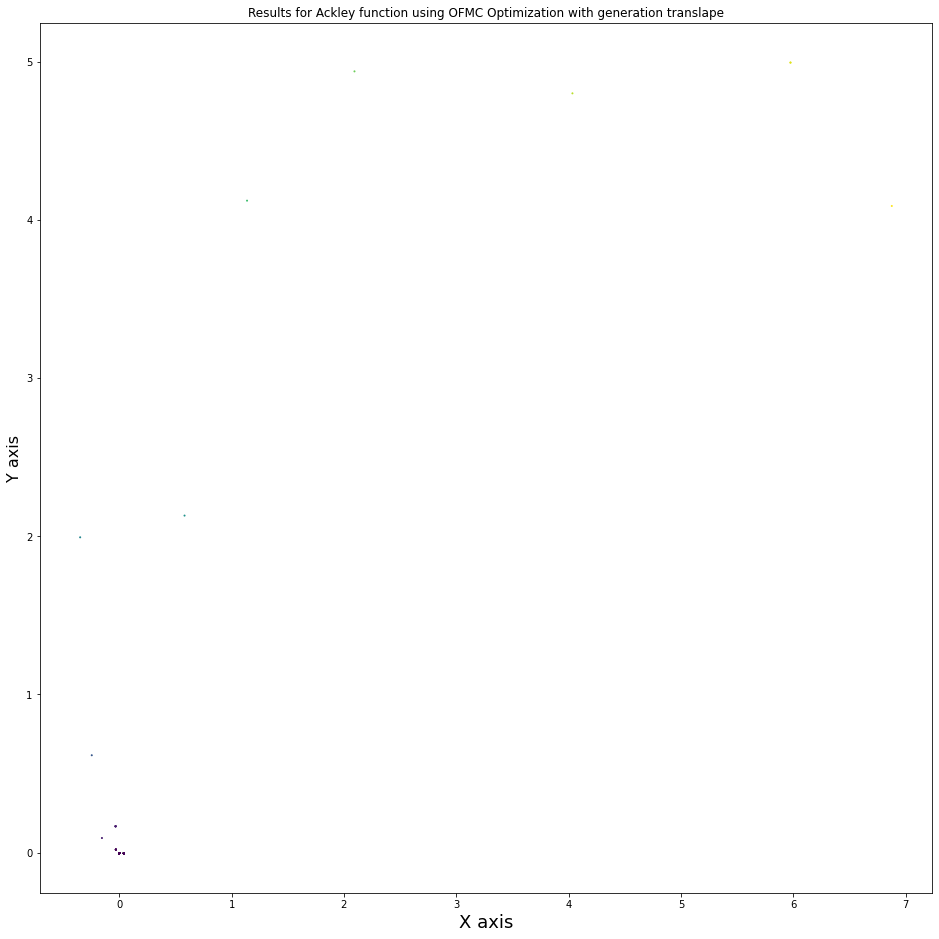

<Figure size 432x288 with 0 Axes>

In [35]:
coordinates = np.asarray(coordinates)
evaluated = do_plot_2d_map(coordinates, 'OFMC Optimization with generation translape', 'omg_2d')

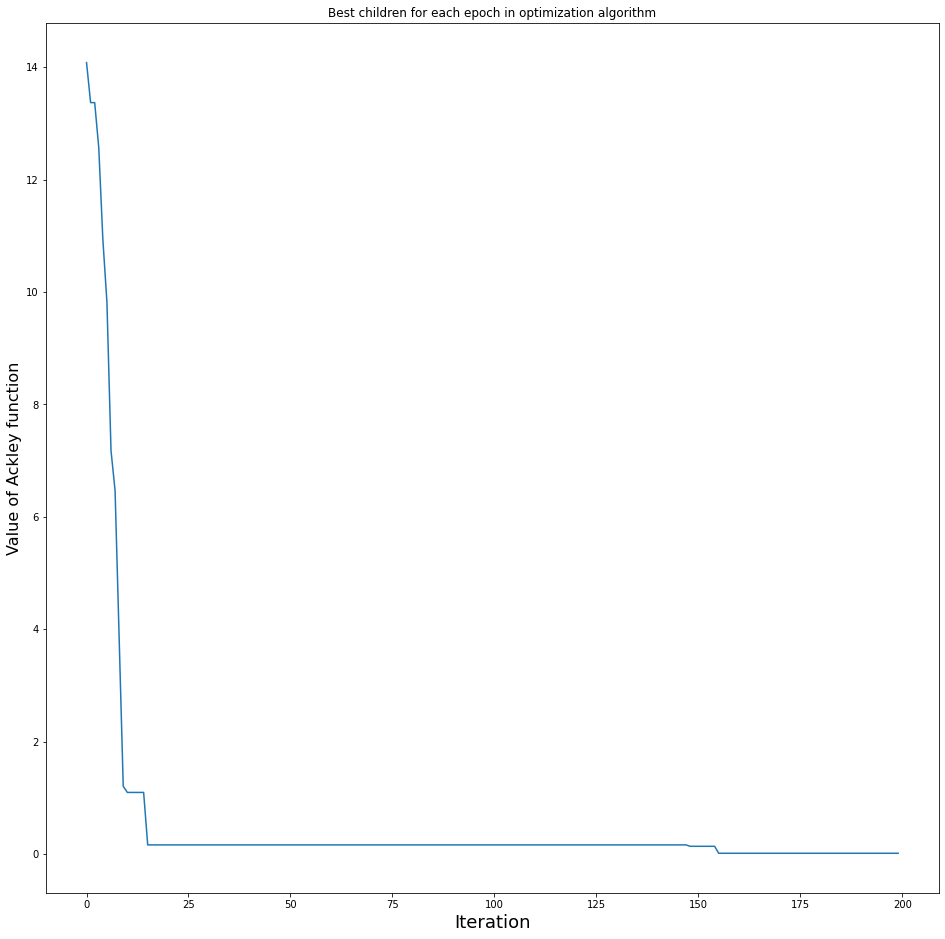

<Figure size 432x288 with 0 Axes>

In [36]:
plot_curve(evaluated[:200], 'omg_curve')

In [37]:
# Optimization results for many father father many children.
optimization_algorithm_mfmc = ManyFatherManyChildren(ACKLEY_FUNCTION, epochs=2000)
best, coordinates = optimization_algorithm_mfmc.runOptimization()
print("Best values for x using many father many children without generation translape:", best)

Best values for x using many father many children without generation translape: [0.13971159 0.16726127]


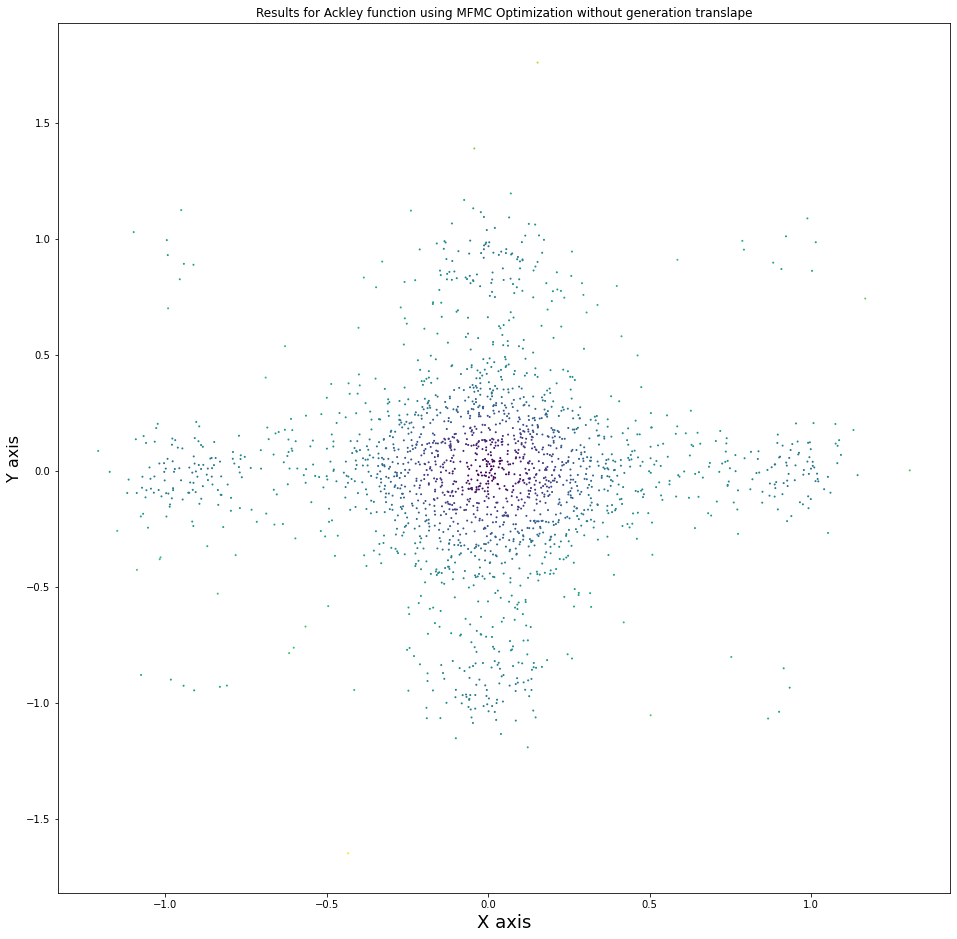

<Figure size 432x288 with 0 Axes>

In [38]:
coordinates = np.asarray(coordinates)
evaluated = do_plot_2d_map(coordinates, 'MFMC Optimization without generation translape', 'mm_2d')

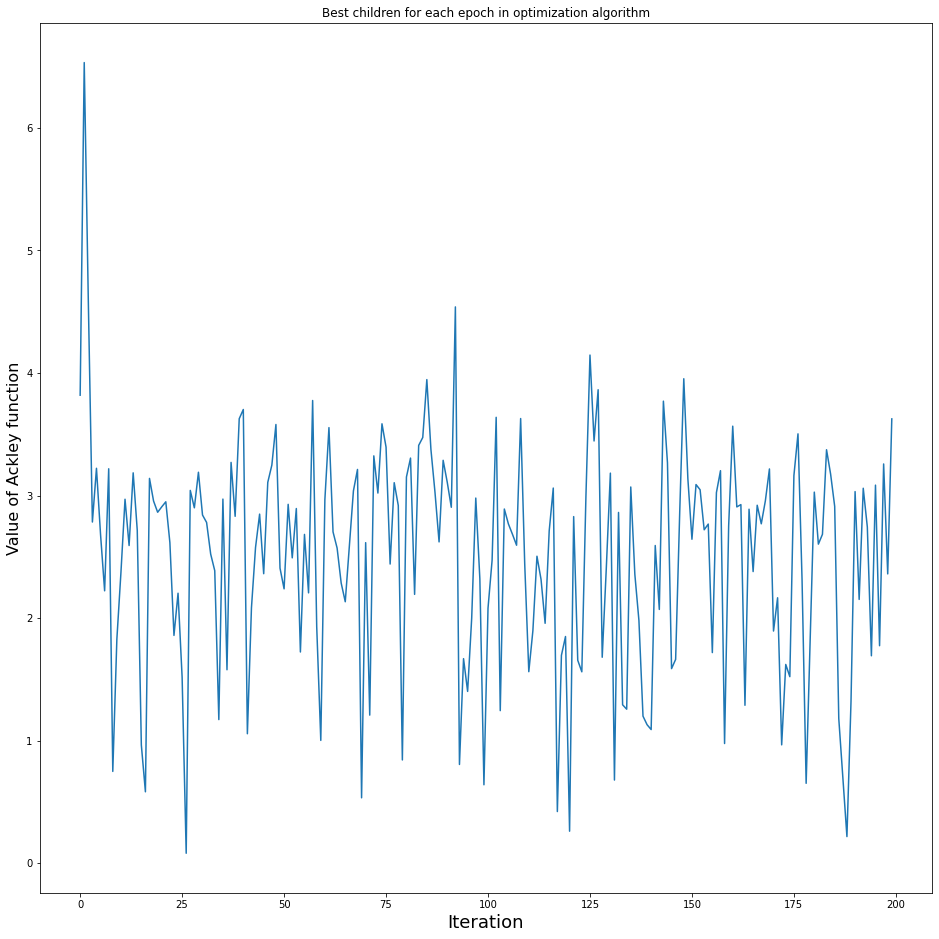

<Figure size 432x288 with 0 Axes>

In [39]:
plot_curve(evaluated[:200], 'mm_curve')

In [40]:
# Optimization results for many father father many children with generational transpose.
optimization_algorithm_mfmcg = ManyFatherManyChildrenGenerational(ACKLEY_FUNCTION, epochs=2000)
best, coordinates  = optimization_algorithm_mfmcg.runOptimization()
print("Best values for x using many father many children with generation translape:", best)

Best values for x using many father many children with generation translape: [ 0.00210597 -0.0022346 ]


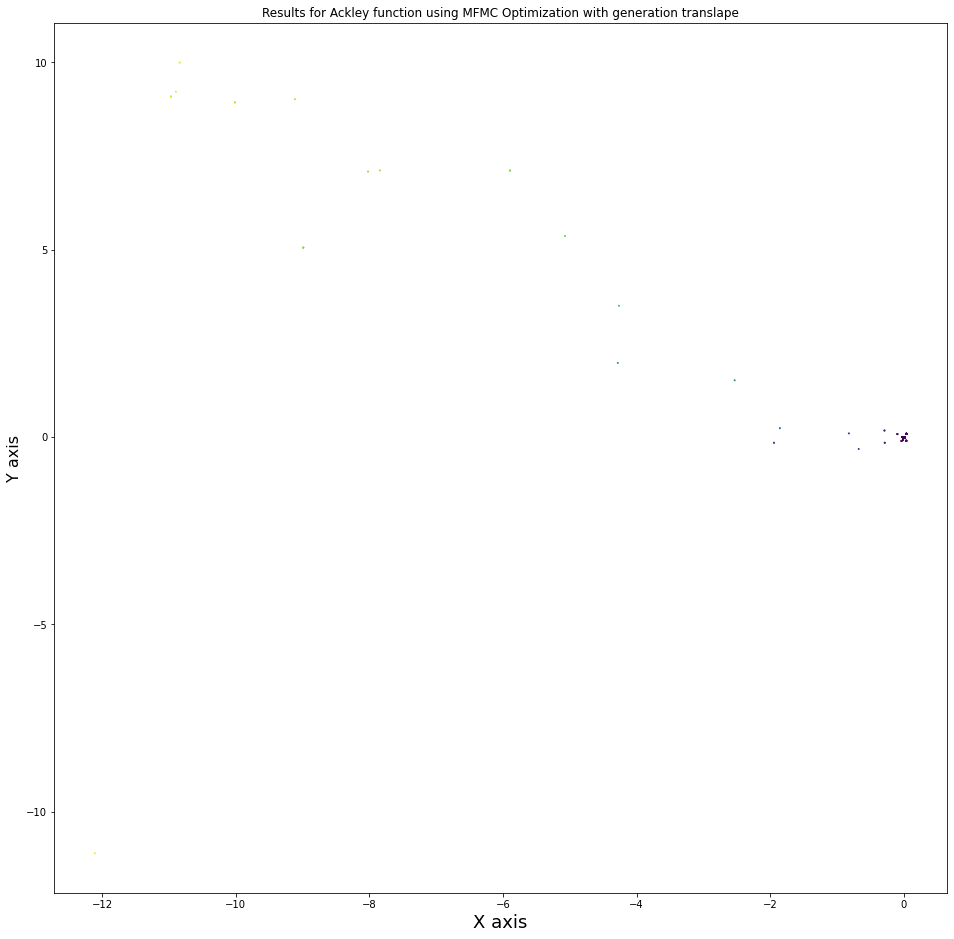

<Figure size 432x288 with 0 Axes>

In [41]:
coordinates = np.asarray(coordinates)
evaluated = do_plot_2d_map(coordinates, 'MFMC Optimization with generation translape', 'mmg_2d')

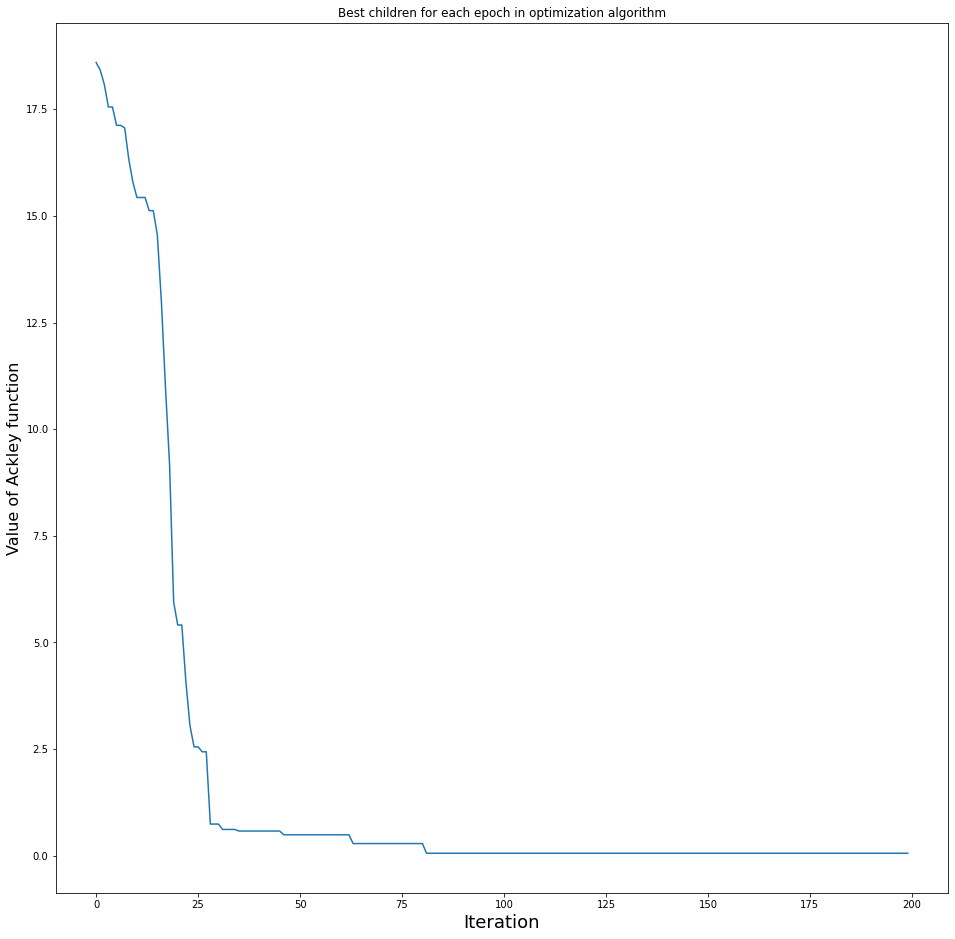

<Figure size 432x288 with 0 Axes>

In [42]:
plot_curve(evaluated[:200], 'mmg_curve')